<a href="https://colab.research.google.com/github/sholtodouglas/learning_from_play/blob/master/notebooks/languageXplay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import argparse

parser = argparse.ArgumentParser(description='LFP training arguments')
parser.add_argument('run_name')
parser.add_argument('--train_datasets', nargs='+', help='Training dataset names')
parser.add_argument('--test_datasets', nargs='+', help='Testing dataset names')
parser.add_argument('-c', '--colab', default=False, action='store_true', help='Enable if using colab environment')
parser.add_argument('-s', '--data_source', default='LOCAL', help='Source of training data')
parser.add_argument('-tfr', '--from_tfrecords', default=False, action='store_true', help='Enable if using tfrecords format')
parser.add_argument('-d', '--device', default='CPU', help='Hardware device to train on')
parser.add_argument('-b', '--batch_size', default=32, type=int)
parser.add_argument('-l', '--layer_size', default=256, type=int, help='Layer size of models, increases size of neural net')
parser.add_argument('-z', '--latent_dim', default=32, type=int, help='Size of the VAE latent space')
parser.add_argument('-g', '--gcbc', default=False, action='store_true', help='Enables GCBC, a simpler model with no encoder/planner')
parser.add_argument('-n', '--num_distribs', default=None, type=int, help='Number of distributions to use in logistic mixture model')
parser.add_argument('-q', '--qbits', default=None, type=int, help='Number of quantisation bits to discrete distributions into. Total quantisations = 2**qbits')
parser.add_argument('-lr', '--learning_rate', type=float, default=3e-4)
parser.add_argument('-t', '--train_steps', type=int, default=5000)
parser.add_argument('-r', '--resume', default=False, action='store_true')


# args = parser.parse_args()

### Sample local config
args = parser.parse_args('''
dummy_run 
--train_dataset UR5
--test_dataset UR5
-tfr
'''.split())

### Sample colab config
# args = parser.parse_args('''
# dummy_run 
# --train_dataset UR5 UR5_slow_gripper UR5_high_transition
# --test_dataset UR5_slow_gripper_test
# -c
# -tfr
# -s GCS
# -d TPU
# -b 512
# -l 1024
# -z 256
# -lr 3e-4
# '''.split())

print(args)

Namespace(batch_size=32, colab=False, data_source='LOCAL', device='CPU', from_tfrecords=True, gcbc=False, latent_dim=32, layer_size=256, learning_rate=0.0003, num_distribs=None, qbits=None, resume=False, run_name='dummy_run', test_datasets=['UR5'], train_datasets=['UR5'], train_steps=5000)


In [ ]:
# {
#     "colab":true,
#     "data_source":"GCS",
#     "from_tfrecords":true,
#     "device":"TPU", 
#     "train_datasets":["UR5", "UR5_slow_gripper","UR5_high_transition"],
#     "test_datasets":["UR5_slow_gripper_test"],
#     "batch_size":512,
#     "layer_size":2048,
#     "latent_dim":256,
#     "gcbc":false,
#     "num_distribs":null,
#     "qbits":null,
#     "learning_rate":3e-4
# }

In [ ]:
from pathlib import Path
from pathy import Pathy
import os
import requests
import json
import pprint
import logging
import glob
import numpy as np
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import random
import datetime
import time
import io
import wandb
from natsort import natsorted

pp = pprint.PrettyPrinter(indent=4)

wandb.login()

In [ ]:
#@title Workpace Setup (Local vs Colab)

# Set up working directory and libraries
if args.colab:
    from google.colab import drive, auth
    print('Using colab setup')
    WORKING_PATH = Path('/content/learning_from_play')
    # Clone repo
    try:
        !git clone 'https://github.com/sholtodouglas/learning_from_play' {WORKING_PATH}
    except: 
        pass
    # Mount drive
    drive.mount('/content/drive')
else:
    print('Using local setup')
    WORKING_PATH = Path().absolute().parent
    print(f'Working path: {WORKING_PATH}')

# Change working directory to learning_from_play
os.chdir(WORKING_PATH)
import lfp
        
# Set up storage directory and datasets
if args.data_source == 'DRIVE':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Drive')
    STORAGE_PATH = Path('/content/drive/My Drive/Robotic Learning')
elif args.data_source == 'GCS':
    assert args.colab, "Must be using Colab"
    print('Reading data from Google Cloud Storage')
    r = requests.get('https://ipinfo.io')
    region = r.json()['region']
    if region != 'Iowa':
        logging.warning(f'You are accessing GCS data from {region}, outside of Iowa region')
    project_id = 'learning-from-play-303306'
    bucket_name = 'iowa_bucket_lfp'
    auth.authenticate_user()
    STORAGE_PATH = Pathy(f'gs://{bucket_name}')
else:
    print('Reading data from local filesystem')
    STORAGE_PATH = WORKING_PATH

print(f'Storage path: {STORAGE_PATH}')
TRAIN_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.train_datasets]
TEST_DATA_PATHS = [STORAGE_PATH/'data'/x for x in args.test_datasets]

# Data Creation

In [5]:
print("Tensorflow version " + tf.__version__)

if args.device == 'TPU':
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
        print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
    except ValueError:
        raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)

    NUM_DEVICES = strategy.num_replicas_in_sync
    print("REPLICAS: ", NUM_DEVICES)
else:
    physical_devices = tf.config.list_physical_devices()
    if args.device == 'GPU':
        tf.config.experimental.set_memory_growth(physical_devices[3], enable=True)
    NUM_DEVICES = 1
    print(physical_devices)

Tensorflow version 2.4.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Dataset

In [6]:
# # Use this to edit modules without needing to restart the kernel
# import importlib
# importlib.reload(lfp.data)
# importlib.reload(lfp.model)
# importlib.reload(lfp.train)


### Config Flags

In [7]:
GLOBAL_BATCH_SIZE = args.batch_size * NUM_DEVICES
dl = lfp.data.PlayDataloader(batch_size=GLOBAL_BATCH_SIZE)

In [8]:
# Train data
train_data = dl.extract(TRAIN_DATA_PATHS, from_tfrecords=args.from_tfrecords)
train_dataset = dl.load(train_data)

{   'acts': TensorSpec(shape=(32, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(32, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(32,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None), dtype=tf.int32, name=None)}


In [9]:
# Validation data
valid_data = dl.extract(TEST_DATA_PATHS, from_tfrecords=args.from_tfrecords)
valid_dataset = dl.load(valid_data)

{   'acts': TensorSpec(shape=(32, 50, 7), dtype=tf.float32, name=None),
    'dataset_path': TensorSpec(shape=(32, None), dtype=tf.int32, name=None),
    'goals': TensorSpec(shape=(32, 50, 11), dtype=tf.float32, name=None),
    'masks': TensorSpec(shape=(32, 50), dtype=tf.float32, name=None),
    'obs': TensorSpec(shape=(32, 50, 18), dtype=tf.float32, name=None),
    'seq_lens': TensorSpec(shape=(32,), dtype=tf.float32, name=None),
    'tstep_idxs': TensorSpec(shape=(32, None), dtype=tf.int32, name=None)}


# Model

# Training Loop

In [17]:
def train_setup():
    model_params = {'obs_dim':dl.obs_dim,
                    'goal_dim':dl.goal_dim,
                    'act_dim':dl.act_dim,
                    'layer_size':args.layer_size, 
                    'latent_dim':args.latent_dim}
    
    actor = lfp.model.create_actor(**model_params, gcbc=args.gcbc, num_distribs=args.num_distribs)

    if args.gcbc:
        encoder = None
        planner = None
    else:
        encoder = lfp.model.create_encoder(**model_params)
        planner = lfp.model.create_planner(**model_params)
        
    trainer = lfp.train.LFPTrainer(dl, 
                                 actor,
                                 encoder=encoder, 
                                 planner=planner, 
                                 probabilistic=args.num_distribs is not None,
                                 distribute_strategy=strategy,
                                 learning_rate=args.learning_rate,
                                 clipnorm=1.0,
                                 gcbc=args.gcbc)
    
    return trainer

if args.device=='CPU':
    trainer = train_setup()
    train_dataset = iter(train_dataset)
    valid_dataset = iter(valid_dataset)
else:
    with strategy.scope():
        trainer = train_setup()   
    train_dataset = iter(strategy.experimental_distribute_dataset(train_dataset))
    valid_dataset = iter(strategy.experimental_distribute_dataset(valid_dataset))

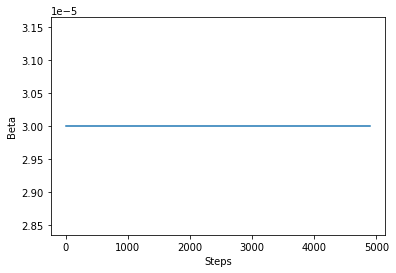

In [18]:
# 0.00001 so far works best for MAE - try lower - 0.00003 with a BETA accel of 10 so far works best, perfect encoder, nicely mapped planner
# recall 0.01 worked okay for probabilistic - proba still too unstable!
beta_sched = lfp.train.BetaScheduler('linear', 
                                   beta=0.00003, 
                                   beta_max=0.00003, 
                                   max_steps=args.train_steps, 
                                   cycles=90, 
                                   duty_cycle=0.5)

In [19]:
progbar = tf.keras.utils.Progbar(args.train_steps, verbose=1, interval=0.5)
best_valid_loss = np.float('inf')

valid_inc = 20
save_inc = 1000

prev_grad_norm = np.float('inf')

In [20]:
model_path = f'/content/drive/My Drive/Robotic Learning/saved_models/{args.run_name}/'

if args.resume:
    # TODO: Fix resume id
    # Fix `load_optimizer_state` given we now have 3 optimizers
    wandb.init(project="learning-from-play_v2", id='12621l2h', resume="must")
    trainer.load_weights(model_path, with_optimizer=True)
    print('Loaded model weights and optimiser state')
    t = wandb.run.step + valid_inc
else:
    wandb.init(project="learning-from-play_v2", config=args)
    wandb.run.name = args.run_name
    t = 0

In [21]:
# v_it = iter(valid_dataset) # for the cluster fig, easier with a non distributed dataset

In [ ]:
while t < args.train_steps:
    start_time = time.time()
    beta = beta_sched.scheduler(t)
    x = next(train_dataset)
    total_train_loss = trainer.distributed_train_step(x, beta)
    
    if t % valid_inc == 0:  
        valid_x = next(valid_dataset)
        if args.gcbc:
            total_val_loss, metrics = trainer.distributed_test_step(valid_x, beta)
        else:
            total_val_loss, metrics, ze, zp = trainer.distributed_test_step(valid_x, beta)

        # validation plotting
        progbar.add(valid_inc, [('Train Loss', metrics['train_loss']), 
                                ('Validation Loss', metrics['valid_loss']), 
                                ('Time (s)', round(time.time() - start_time, 1))])

        wandb.log(metrics, step=t)
          
    if t % save_inc == 0:
        trainer.save_weights(model_path, args)
        if not args.gcbc:
            # z_enc, z_plan = lfp.plotting.produce_cluster_fig(next(valid_dataset), trainer.encoder, trainer.planner, TEST_DATA_PATHS[0], num_take=dl.batch_size)
            # wandb.log({'z_enc':z_enc, 'z_plan':z_plan}, step=t)
            latent_fig = lfp.plotting.project_enc_and_plan(ze, zp)
            #latent_img = plot_to_image(latent_fig)
    t += 1